In [2]:
from pathlib import Path
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

train_image_path = Path('Train_plain_010')
validation_image_path = Path('Val_010')
test_image_path = Path('Final_test_0_10/Test_0_10')

train_dataset = ImageFolder(root=train_image_path, transform=transform)
validation_dataset = ImageFolder(root=validation_image_path, transform=transform)
test_dataset = ImageFolder(root=test_image_path, transform=transform)

BS = 16 
validation_loader = DataLoader(validation_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# CBAM modules unchanged
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        mid = max(1, channels // reduction)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, mid, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        a1 = self.fc(self.avg_pool(x))
        a2 = self.fc(self.max_pool(x))
        return x * self.sigmoid(a1 + a2)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        mx, _ = torch.max(x, dim=1, keepdim=True)
        av = torch.mean(x, dim=1, keepdim=True)
        m = torch.cat([mx, av], dim=1)
        return x * self.sigmoid(self.conv(m))

class CBAMResBlock(nn.Module):
    def __init__(self, channels, dropout=0.2, use_residual=True):
        super().__init__()
        self.use_residual = use_residual
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(channels)
        self.ca    = ChannelAttention(channels)
        self.sa    = SpatialAttention()
        self.dropout = nn.Dropout2d(dropout)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x if self.use_residual else torch.zeros_like(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = self.ca(out)
        out = self.sa(out)
        if self.use_residual:
            out = out + residual
        return self.relu(out)

class RevisedAutoencoder(nn.Module):
    def __init__(self, latent_channels=128):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(inplace=True)
        )  # [B,32,256,256]
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(inplace=True)
        )  # [B,64,128,128]
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True)
        )  # [B,128,64,64]
        self.enc4 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(inplace=True)
        )  # [B,256,32,32]

        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, latent_channels, 1),
            nn.BatchNorm2d(latent_channels),
            nn.ReLU(inplace=True)
        ) 

        # Decoder
        self.dec1_conv = nn.ConvTranspose2d(latent_channels, 128, 4, 2, 1) 
        self.dec1_cbam = CBAMResBlock(128 + 128, dropout=0.2, use_residual=False)
        self.dec1_bn   = nn.BatchNorm2d(128)


        self.dec2_conv = nn.ConvTranspose2d(128, 64, 4, 2, 1)  # [B,64,128,128]
        self.dec2_cbam = CBAMResBlock(64, dropout=0.2, use_residual=False)
        self.dec2_bn   = nn.BatchNorm2d(64)

   
        self.dec3_conv = nn.ConvTranspose2d(64, 32, 4, 2, 1)  # [B,32,256,256]
        self.dec3_cbam = CBAMResBlock(32, dropout=0.2, use_residual=False)
        self.dec3_bn   = nn.BatchNorm2d(32)


        self.dec4_conv = nn.ConvTranspose2d(32, 16, 4, 2, 1)  # [B,16,512,512]
        self.dec4_cbam = CBAMResBlock(16, dropout=0.2, use_residual=False)
        self.dec4_bn   = nn.BatchNorm2d(16)

        # Output
        self.out_conv = nn.Conv2d(16, 3, 3, 1, 1)
        self.out_act  = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)

        # Bottleneck
        z  = self.bottleneck(x4)

        d1 = self.dec1_conv(z)
        d1 = torch.cat([d1, x3], dim=1)
        d1 = self.dec1_cbam(d1)
        d1 = self.dec1_bn(d1[:, :128, :, :])

        d2 = self.dec2_conv(d1)
        d2 = self.dec2_cbam(d2)
        d2 = self.dec2_bn(d2)

        d3 = self.dec3_conv(d2)
        d3 = self.dec3_cbam(d3)
        d3 = self.dec3_bn(d3)

        d4 = self.dec4_conv(d3)
        d4 = self.dec4_cbam(d4)
        d4 = self.dec4_bn(d4)

        out = self.out_conv(d4)
        return self.out_act(out), z

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = RevisedAutoencoder(latent_channels=128).to(device)

In [4]:
import torch.nn.functional as F

window_size = 7
sigma = 1.5

coords = torch.arange(window_size).float() - window_size//2
gaussian_kernel = torch.exp(-(coords**2).unsqueeze(0) - (coords**2).unsqueeze(1) / (2*(sigma**2)))
gaussian_kernel = gaussian_kernel / gaussian_kernel.sum()
gaussian_kernel = gaussian_kernel.view(1, 1, window_size, window_size)
def ssim_loss(img, recon):
    C = img.shape[1]
    window = gaussian_kernel.to(img.device, img.dtype).repeat(C, 1, 1, 1)

    mu_img = F.conv2d(img, window, padding=window_size//2, groups=C)
    mu_rec = F.conv2d(recon, window, padding=window_size//2, groups=C)
    
    mu_img_sq = mu_img * mu_img
    mu_rec_sq = mu_rec * mu_rec
    mu_img_rec = mu_img * mu_rec
    sigma_img = F.conv2d(img * img, window, padding=window_size//2, groups=C) - mu_img_sq
    sigma_rec = F.conv2d(recon * recon, window, padding=window_size//2, groups=C) - mu_rec_sq
    sigma_img_rec = F.conv2d(img * recon, window, padding=window_size//2, groups=C) - mu_img_rec
    C1 = (0.01 ** 2)
    C2 = (0.03 ** 2)
    
    ssim_n = (2 * mu_img_rec + C1) * (2 * sigma_img_rec + C2)
    ssim_d = (mu_img_sq + mu_rec_sq + C1) * (sigma_img + sigma_rec + C2)
    ssim_map = ssim_n / (ssim_d + 1e-8)
    loss = torch.clamp((1 - ssim_map) / 2, min=0, max=1)
    return loss.mean()


In [ ]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 25
for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0.0
    for images, _ in train_loader: 
        images = images.to(device)
        optimizer.zero_grad()

        recon, z = model(images)
        loss_mse = mse_loss_fn(recon, images)
        loss_ssim = ssim_loss(images, recon)
        loss = 0.15*loss_mse + 0.85*loss_ssim

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{num_epochs} - Training Loss: {avg_loss:.4f}")

torch.save(model.state_dict(), "AE_0_10_plain_revisedmmm.pth")
print("Model weights saved!")


AUC-ROC Score: 0.6141


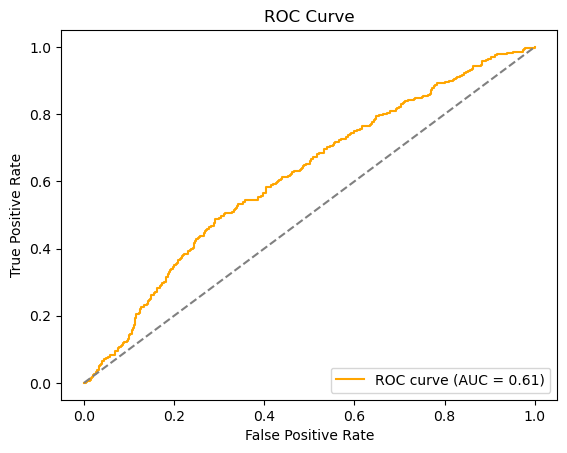

Best Threshold (by F1): 0.06701747


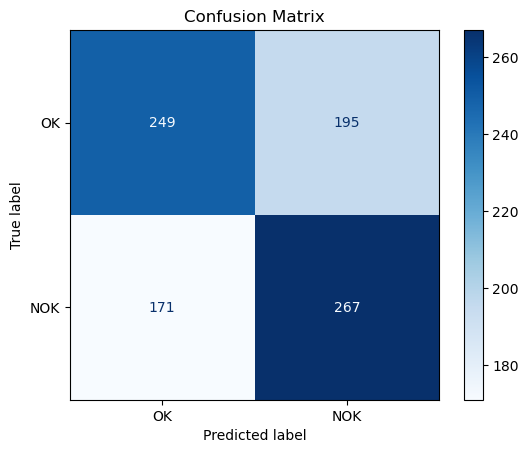

Accuracy:  0.5850
Precision: 0.5779
Recall:    0.6096
F1-Score:  0.5933


In [33]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt


def decision_function(segm_map):
    scores = []
    for i in range(segm_map.size(0)):
        vals, _ = torch.topk(segm_map[i].flatten(), k=1500)
        scores.append(vals.mean())
    return torch.stack(scores)


model.eval()
y_true = []
y_score = []
error_map_min, error_map_max = float('inf'), -float('inf')
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        recon,_ = model(images)
        err_map = ((images - recon) ** 2).mean(dim=1)  
        err_map_cropped = err_map
        scores = decision_function(err_map_cropped)
        y_true.extend(labels.cpu().tolist())
        y_score.extend(scores.cpu().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)


auc = roc_auc_score(y_true, y_score)
print(f"AUC-ROC Score: {auc:.4f}")


fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold (by F1): {best_threshold:.8f}")


y_pred = (y_score >= best_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['OK','NOK'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


acc = accuracy_score(y_true, y_pred)
pre = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {pre:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")


Best threshold (by F1): 0.0151
AUROC:0.8421447912771254


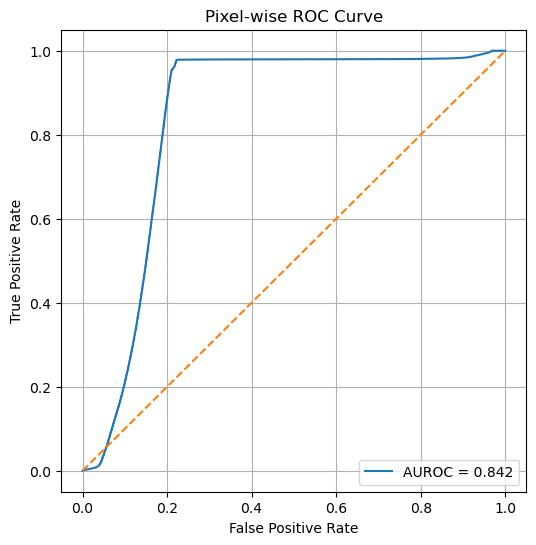

In [36]:
import os, glob, random
import numpy as np
import torch
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, jaccard_score, roc_curve

image_folder = "Final_test_0_10/Test_0_10/NOK"
mask_folder = "Masks_010/Pixel_masks_010"
resize_to = (512, 512)

all_image_paths = sorted(glob.glob(os.path.join(image_folder, "*.jpeg")))
valid_paths = [p for p in all_image_paths if os.path.exists(os.path.join(mask_folder, os.path.splitext(os.path.basename(p))[0] + ".png"))]
selected_paths = random.sample(valid_paths, 50)

orig_images, gt_masks = [], []
for path in selected_paths:
    base = os.path.splitext(os.path.basename(path))[0]
    mask_path = os.path.join(mask_folder, f"{base}.png")
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, resize_to).astype(np.float32) / 255.0
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, resize_to, interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype(np.uint8)
    
    orig_images.append(img)
    gt_masks.append(mask)

model.eval()
device = next(model.parameters()).device
error_maps, all_scores, all_gts = [], [], []

for img, mask in zip(orig_images, gt_masks):
    x = torch.from_numpy(img.transpose(2, 0, 1)).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        recon = out[0] if isinstance(out, tuple) else out
    recon = recon.squeeze().cpu().numpy().transpose(1, 2, 0)
    recon = np.clip(recon, 0, 1)
    
    err_map = np.abs(img - recon).mean(axis=2)
    error_maps.append(err_map)
    
    all_scores.extend(err_map.flatten())
    all_gts.extend(mask.flatten())

all_scores = np.array(all_scores)
all_gts = np.array(all_gts)

thresholds = np.linspace(0, 1, 200)
f1s = [f1_score(all_gts, all_scores >= t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1s)]
print(f"Best threshold (by F1): {best_threshold:.4f}")


fpr, tpr, _ = roc_curve(all_gts, all_scores)
auc = roc_auc_score(all_gts, all_scores)
print(f"AUROC:{auc}")
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUROC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Pixel-wise ROC Curve")
plt.legend()
plt.grid()
plt.show()